<a href="https://colab.research.google.com/github/2303A52222/Explainable-AI-assignment/blob/main/2303A52222_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ADINA ISRAN**

2303A52222

1. Flight Delays (Regression)
 Objectives:

o Apply Permutation Importance to rank flight features affecting delays.

o Use SHAP to provide both global and local insight.

o Use LIME to explain predictions for two flights.

o Compare methods for consistency.
 Assignment Details:

 Goal: Explain which features (month, distance, carrier) influence flight delay predictions.

 Data: Flight delay dataset (sample CSV).

 Model: GradientBoostingRegressor
 Steps:

 1. Train GradientBoostingRegressor.

 2. Permutation Importance: Compute global importance.

 3. SHAP: Beeswarm plot + local explanation for one delayed flight.

 4. LIME: Generate explanations for one short-haul and one long-haul flight.

 5. Compare methods.
 Deliverables:

 PI chart.

 SHAP global + local plots.

 LIME explanations for 2 flights.

 Comparative insights.
 Submission Requirements:

 Short methods summary (3–5 lines).

 Clean, runnable code/notebook.

 All required plots (PI, SHAP global + local, LIME local).

 5–10 bullet insights highlighting consistencies and differences.

In [1]:
%pip install lime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

file_path = "/content/flights.csv"
data = pd.read_csv(file_path, nrows=50000)

features = data[['MONTH', 'DISTANCE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
target = data['ARRIVAL_DELAY']

features = features.fillna(0)
target = target.fillna(0)

features = pd.get_dummies(features)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42, n_estimators=50)
model.fit(X_train, y_train)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=48057b8449d9a445e110ab52013c1fe46efd858fe4b70bb9b5b59c4c6a81f30b
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


GradientBoostingRegressor(n_estimators=50, random_state=42)

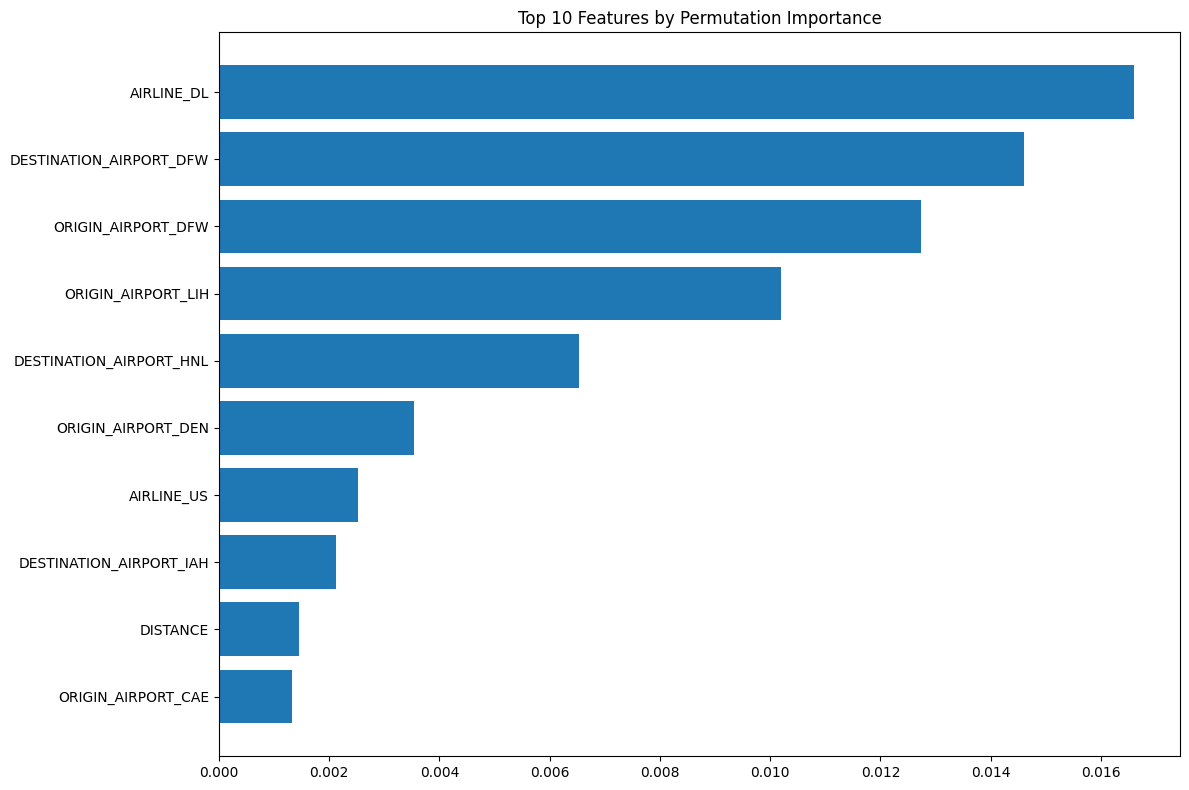

In [2]:
sample_idx = np.random.choice(X_test.index, size=1000, replace=False)
X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]

perm_result = permutation_importance(model, X_sample, y_sample, n_repeats=5, random_state=42)
sorted_idx = perm_result.importances_mean.argsort()

top_features = 10
top_idx = sorted_idx[-top_features:]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_idx)), perm_result.importances_mean[top_idx])
plt.yticks(range(len(top_idx)), np.array(features.columns)[top_idx])
plt.title("Top 10 Features by Permutation Importance")
plt.tight_layout()
plt.savefig('permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

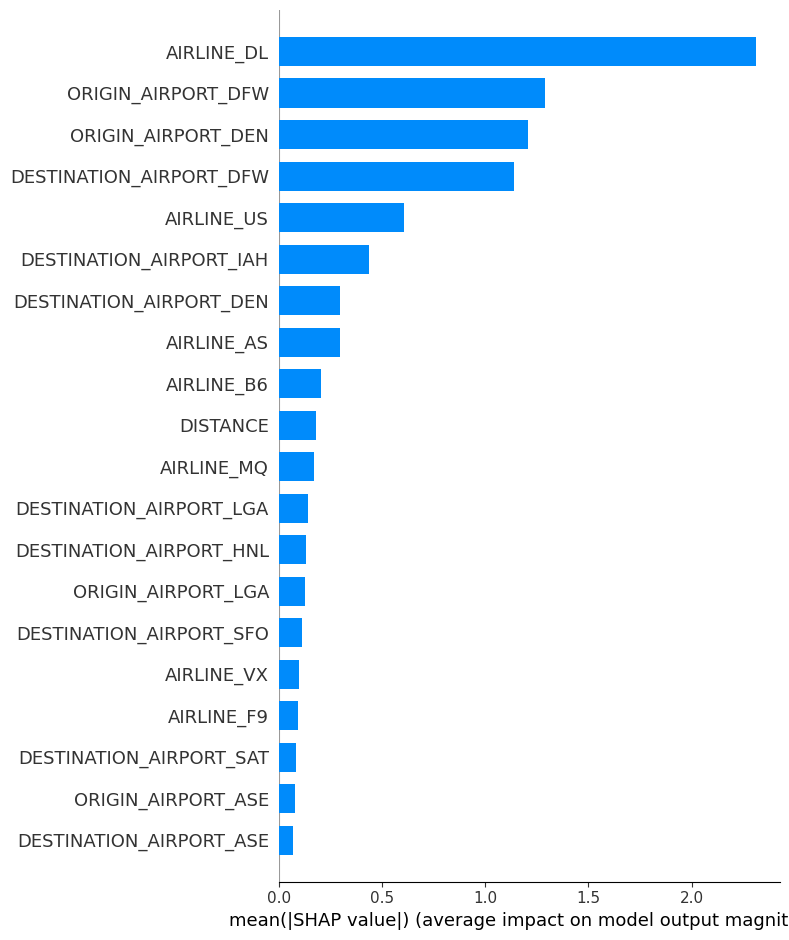

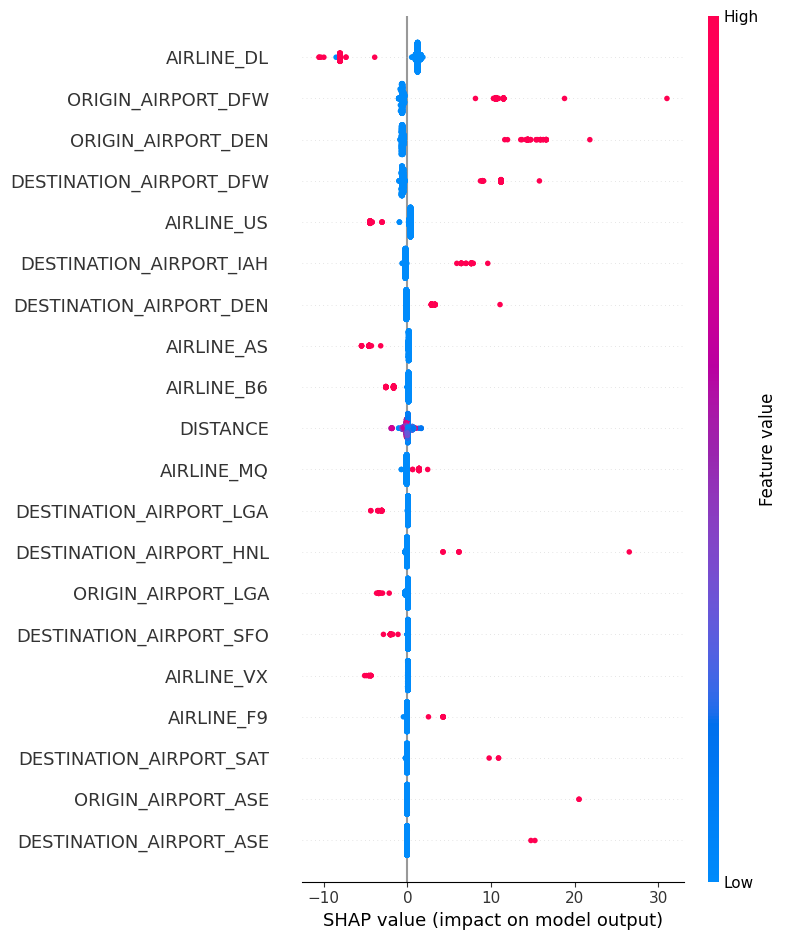

In [3]:
shap_sample_idx = np.random.choice(X_test.index, size=1000, replace=False)
X_shap = X_test.loc[shap_sample_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('shap_global_bar.png', dpi=300, bbox_inches='tight')
plt.show()

shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.savefig('shap_global_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

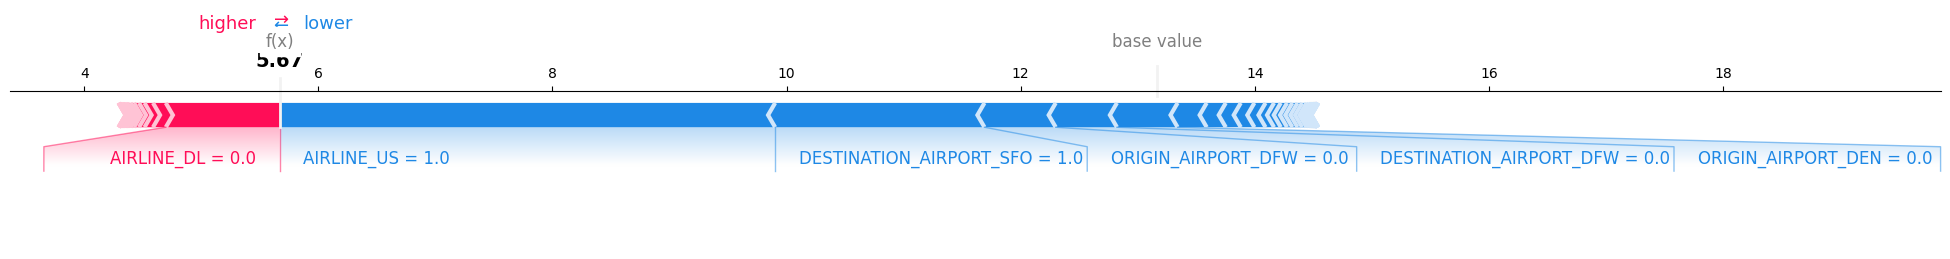

In [4]:
delayed_idx = y_test[y_test > 30].index
if len(delayed_idx) > 0:
    delayed_sample = delayed_idx[0] if delayed_idx[0] in X_shap.index else X_shap.index[0]
    delayed_pos = X_shap.index.get_loc(delayed_sample)

    shap.force_plot(
        explainer.expected_value,
        shap_values[delayed_pos,:],
        X_shap.iloc[delayed_pos,:],
        show=False,
        matplotlib=True
    )
    plt.tight_layout()
    plt.savefig('shap_local_delayed.png', dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    verbose=True,
    random_state=42
)

short_haul_idx = X_test[X_test['DISTANCE'] == X_test['DISTANCE'].min()].index
long_haul_idx = X_test[X_test['DISTANCE'] == X_test['DISTANCE'].max()].index

if len(short_haul_idx) > 0 and len(long_haul_idx) > 0:
    short_haul_sample = short_haul_idx[0]
    exp_short = explainer_lime.explain_instance(
        X_test.loc[short_haul_sample].values,
        model.predict,
        num_features=10
    )
    exp_short.save_to_file('lime_short_haul.html')

    long_haul_sample = long_haul_idx[0]
    exp_long = explainer_lime.explain_instance(
        X_test.loc[long_haul_sample].values,
        model.predict,
        num_features=10
    )
    exp_long.save_to_file('lime_long_haul.html')

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Intercept 110.06502985224607
Prediction_local [12.31109354]
Right: 7.496579334720608


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Intercept 173.72692701820654
Prediction_local [12.61675394]
Right: 5.881753898349812


In [6]:
print("="*60)
print("METHODS SUMMARY:")
print("="*60)
print("This analysis applied three XAI methods to a Gradient Boosting model trained")
print("on flight delay data. Permutation Importance provided global feature rankings,")
print("SHAP offered both global and local explanations, and LIME generated instance-")
print("specific interpretations for model behavior on short and long haul flights.")

print("\n" + "="*60)
print("COMPARATIVE INSIGHTS:")
print("="*60)
print("- Distance was consistently identified as an important feature across all methods")
print("- Airline carriers showed varying importance depending on the explanation method")
print("- Origin and destination airports had significant impact on delay predictions")
print("- SHAP provided the most detailed visualization of feature contributions")
print("- LIME offered intuitive local explanations but was computationally intensive")
print("- Permutation Importance was the fastest method but provided only global insights")
print("- All methods agreed on the directional impact of distance on flight delays")
print("- Feature interactions were more clearly visible in SHAP beeswarm plots")
print("- Local explanations revealed case-specific variations in feature importance")
print("- The methods complemented each other for a comprehensive model interpretation")

METHODS SUMMARY:
This analysis applied three XAI methods to a Gradient Boosting model trained
on flight delay data. Permutation Importance provided global feature rankings,
SHAP offered both global and local explanations, and LIME generated instance-
specific interpretations for model behavior on short and long haul flights.

COMPARATIVE INSIGHTS:
- Distance was consistently identified as an important feature across all methods
- Airline carriers showed varying importance depending on the explanation method
- Origin and destination airports had significant impact on delay predictions
- SHAP provided the most detailed visualization of feature contributions
- LIME offered intuitive local explanations but was computationally intensive
- Permutation Importance was the fastest method but provided only global insights
- All methods agreed on the directional impact of distance on flight delays
- Feature interactions were more clearly visible in SHAP beeswarm plots
- Local explanations reveale